In [1]:
from PIL import Image
import sys
import os
import urllib
import tensorflow.contrib.tensorrt as trt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np
import time
from tf_trt_models.detection import download_detection_model, build_detection_graph

%matplotlib inline

/home/jetbot/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jetbot/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jetbot/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jetbot/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: 

In [2]:
MODEL = 'ssd_mobilenet_v1_coco'
DATA_DIR = './data/'
CONFIG_FILE = MODEL + '.config'   # ./data/ssd_inception_v2_coco.config 
CHECKPOINT_FILE = 'model.ckpt'    # ./data/ssd_inception_v2_coco/model.ckpt
IMAGE_PATH = './data/huskies.jpg'

### Download the pretrained model

Download the model configuration file and checkpoint containing pretrained weights by using the following command.  

For improved performance, increase the non-max suppression score threshold in the downloaded config file from 1e-8 to something greater, like 0.1.

In [3]:
config_path, checkpoint_path = download_detection_model(MODEL, 'data')

### Build the frozen graph

In [4]:
frozen_graph, input_names, output_names = build_detection_graph(
    config=config_path,
    checkpoint=checkpoint_path,
    score_threshold=0.3,
    batch_size=1
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from data/ssd_mobilenet_v1_coco_2018_01_28/model.ckpt
INFO:tensorflow:Restoring parameters from data/ssd_mobilenet_v1_coco_2018_01_28/model.ckpt
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.e

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: .generated_model/saved_model/saved_model.pb


INFO:tensorflow:SavedModel written to: .generated_model/saved_model/saved_model.pb


INFO:tensorflow:Writing pipeline config file to .generated_model/pipeline.config


INFO:tensorflow:Writing pipeline config file to .generated_model/pipeline.config


### Optimize the model with TensorRT

In [5]:
print(output_names)

['detection_boxes', 'detection_classes', 'detection_scores', 'num_detections']


In [6]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

INFO:tensorflow:Running against TensorRT version 5.0.6


INFO:tensorflow:Running against TensorRT version 5.0.6


In [7]:
with open('./data/ssd_inception_v2_coco_trt.pb', 'wb') as f:
    f.write(trt_graph.SerializeToString())

### Create session and load graph

In [8]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

tf_sess = tf.Session(config=tf_config)

tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

### Load and Preprocess Image

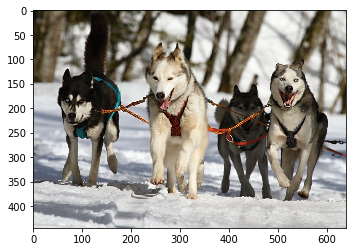

In [9]:
image = Image.open(IMAGE_PATH)

plt.imshow(image)

image_resized = np.array(image.resize((300, 300)))
image = np.array(image)

### Run network on Image

In [10]:
scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image_resized[None, ...]
})

boxes = boxes[0] # index by 0 to remove batch dimension
scores = scores[0]
classes = classes[0]
num_detections = num_detections[0]

### Display Results

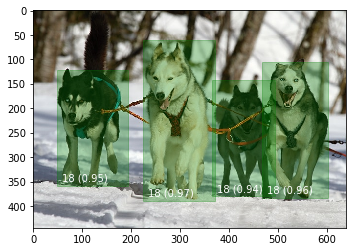

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image)

# plot boxes exceeding score threshold
for i in range(int(num_detections)):
    # scale box to image coordinates
    box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])

    # display rectangle
    patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')

plt.show()

### Benchmark

In [13]:
num_samples = 50

t0 = time.time()
for i in range(num_samples):
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_resized[None, ...]
    })
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / num_samples))

Average runtime: 0.065338 seconds


### Close session to release resources

In [14]:
tf_sess.close()